# How to use CLIPModel and fine tune it

In [37]:
import os
import sys

import clip

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

module_path = os.path.join(os.getcwd(), '../src')
sys.path.append(module_path)

from gan_t2i.datasets.DatasetFactory import DatasetFactory
from gan_t2i.models.CLIP import CLIPModel

In [38]:
""" 
Uncomment if you want to compute the mean and the standard deviation
"""
if False:
    dataset = DatasetFactory.Flowers(os.path.join(os.getcwd(), "..", "data"), transform_img=transforms.ToTensor())
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    # Calcolare media e deviazione standard
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for images, _, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    print("mean: ", mean, "\nstd: ", std)

In [39]:
""" Image transformations """
transform_img = transforms.Compose([
    transforms.Resize(224, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    
    # Previously computed mean and std
    transforms.Normalize([0.4355, 0.3777, 0.2879], [0.2571, 0.2028, 0.2101])
])

In [40]:
""" Text Transformation

You need to tokenize your text before passing it to the model.
"""
def tokenize_text(text):
    
    # Try except is needed due to error thrown by CLIP model that limit the context size
    # to 77 tokens so we need to split the text in smaller chunks and keep only a small portion
    # of it if the text is too long
    try:
        return clip.tokenize([text])[0]
    except:
        return clip.tokenize([text.split(".")[0]])[0]    
    

In [41]:
dataset = DatasetFactory.Flowers(os.path.join(os.getcwd(), "..", "data"), transform_img=transform_img, transform_caption=tokenize_text)

Captions already downloaded
images already downloaded
Captions already extracted
images already extracted
The dataset is already stored in HDF5 format


In [43]:
# Create train, validation and test set     NOTE: We are using small subset of the dataset for this example
#                                                 This may and will cause overfitting this is only a demo
# SMALL DATASET                                           
#train_size = int(0.50 * len(dataset))       
#val_size = int(0.20 * len(dataset))
#test_size = int(0.05 * len(dataset))

train_size = int(0.5 * len(dataset))       
val_size = int(0.25 * len(dataset))
test_size = int(0.12 * len(dataset))

# Cration of train, validation and test set indices and samplers
train_indices = list(range(train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, train_size + val_size + test_size))

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Creation of train, validation and test dataloaders
train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler, pin_memory=True)
val_loader = DataLoader(dataset, batch_size=64, sampler=val_sampler, pin_memory=True)
test_loader = DataLoader(dataset, batch_size=64, sampler=test_sampler, pin_memory=True)

In [48]:
model = CLIPModel() # by default load ViT-B/32

Model loaded on device: cuda


In [49]:
checkpoints_path = os.path.join(os.getcwd(), "checkpoints_CLIP")
log_path = os.path.join(os.getcwd(), "logs")

In [50]:
model.fit( 
    train_dataloader = train_loader, 
    val_dataloader = val_loader,
    num_epochs = 1, 
    save_path=checkpoints_path
    )

Training on device:  cuda


Epoch [1/1] Summary:
	=> Train Loss: 2.442503
	=> Val Loss: 2.833185



Plot the metrics saved by the default csv logger

In [22]:
csv_filename = "metrics.csv"
csv_path = os.path.join(log_path, "CLIPModel", "version_1", csv_filename)

metrics = pd.read_csv(csv_path) 

In [23]:
display(metrics)

,epoch,iteration,loss,step,train_loss,val_loss
0,NaN,1.0,3.652344,0,NaN,NaN
1,NaN,2.0,4.078125,1,NaN,NaN
2,NaN,3.0,4.117188,2,NaN,NaN
3,NaN,4.0,4.011719,3,NaN,NaN
4,NaN,5.0,3.804688,4,NaN,NaN
...,...,...,...,...,...,...
1295,NaN,1277.0,0.612793,1276,NaN,NaN
1296,NaN,1278.0,0.562988,1277,NaN,NaN
1297,NaN,1279.0,0.610352,1278,NaN,NaN
1298,NaN,1280.0,0.571777,1279,NaN,NaN


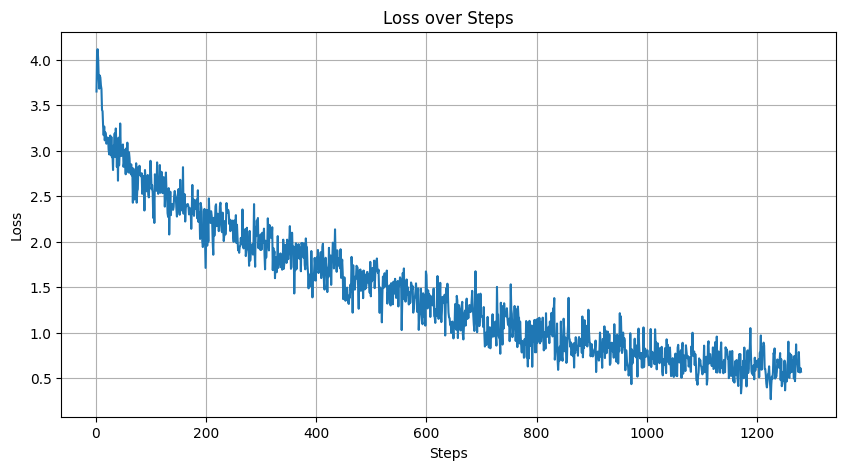

In [24]:
steps = metrics["iteration"].dropna().to_numpy()
losses = metrics["loss"].dropna().to_numpy()

plt.figure(figsize=(10,5))
plt.plot(steps, losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss over Steps")
plt.grid()
plt.show()

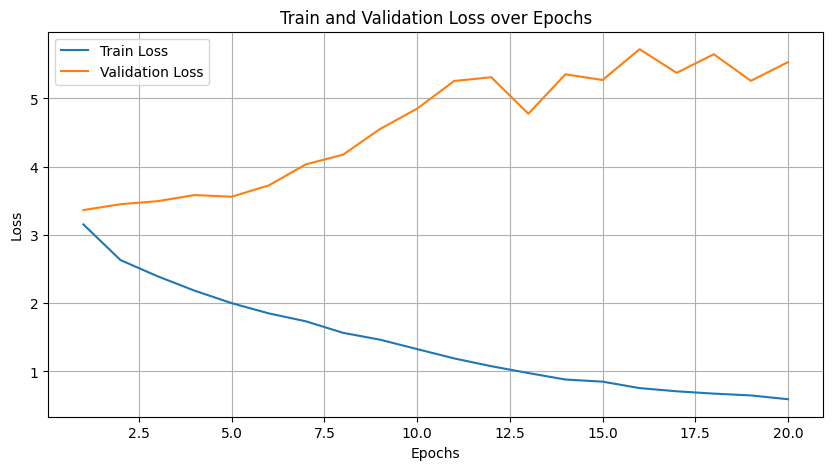

In [25]:
epochs = metrics["epoch"].dropna().to_numpy()
tr_losses = metrics["train_loss"].dropna().to_numpy()
val_losses = metrics["val_loss"].dropna().to_numpy()

plt.figure(figsize=(10,5))
plt.plot(epochs, tr_losses)
plt.plot(epochs, val_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss over Epochs")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid()
plt.show()

Load the checkpoint created at the end of epoch w

In [26]:
checkpoint_path = os.path.join(checkpoints_path, "CLIPModel_epoch-1.pt")
loaded_model = CLIPModel.load(checkpoint_path)

Model loaded on device: cuda


In [27]:
from gan_t2i.models.CLIP import ContrastiveLoss

total_test_loss = 0.0
for images, captions, _ in test_loader:
    with torch.no_grad():
        images = images.to("cuda" if torch.cuda.is_available() else "cpu")
        captions = captions.to("cuda" if torch.cuda.is_available() else "cpu")

        # Get the image and text features
        image_features = loaded_model.encode_image(images)
        text_features = loaded_model.encode_text(captions)
        
        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        ground_truth = torch.arange(len(images)).to("cuda" if torch.cuda.is_available() else "cpu")
        total_test_loss += ContrastiveLoss(image_features, text_features).item()
    
print("Total test loss: ", total_test_loss / len(test_loader))

Total test loss:  3.598933293269231


### So first of alla using the CLIP Model with the weights related to ViT-B/32 is possible to train the model on the Training set 
### The dataset in this example is very small on Flowers (0.05% percent of the total dataset) so roughly 10K images 
### The loss function is the ContrastiveLoss which computes correlation between text and images
### The wights of the CLIP network are saved in the folder checkpoints_CLIP
### At the end we evaluate the performance on the Test Set

----------------------

Load data from Checkpoint_CLIP and continue to train from which you stopped

In [ ]:
# Carico il modello fino all' epoca N
checkpoints_path = os.path.join(os.getcwd(), "checkpoints_CLIP")
checkpoint_path = os.path.join(checkpoints_path, "CLIPModel_epoch-1.pt")  # - CLIPModel_epoch-N.pt
loaded_model = CLIPModel.load(checkpoint_path)

In [ ]:
checkpoints_path = os.path.join(os.getcwd(), "checkpoints_CLIP")
model.fit( 
    train_dataloader = train_loader, 
    val_dataloader = val_loader,
    num_epochs = 1, 
    save_path=checkpoints_path,
    starting_epoch=1
    )